# FELion Spectra
New Baseline correction and analysing method for FELion Spectra

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import rampy as rp
import rampy
from scipy.interpolate import interp1d as interpolate

%matplotlib inline
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi']=(100)

In [10]:
filename = "./DATA/16_11_18-3.felix"

v = {'lamb':10e5, 'smooth':0.05, 'p_value':0.01, 'iterations':10, 'mainfont':15, 'subfont':12}

# Making the plot vertical

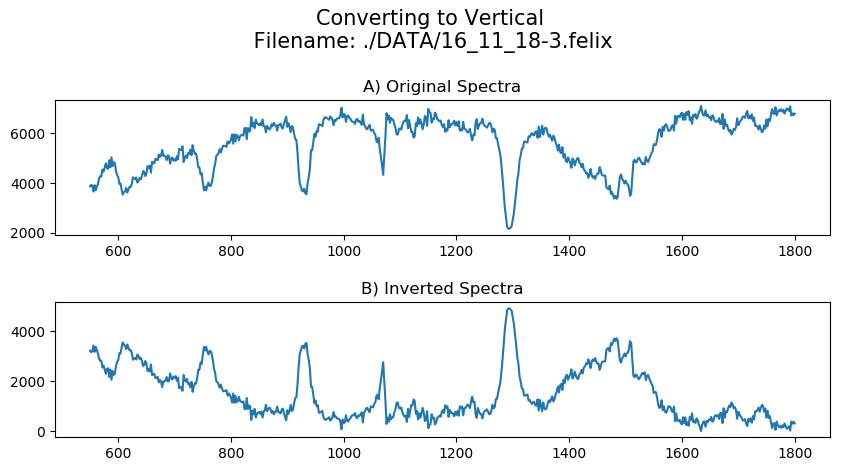

In [11]:
data = np.genfromtxt(filename)
x, y = data[:,0], data[:,2]
shape = data.shape[0]
y1 = y.max()-y

# the frequency regions devoid of signal, used by rp.baseline()
# bir is not used for als method; this is just to overcome the module program and no significant here
bir = np.array([[x.min(),x.mean(), x.max()]]) 

plt.figure()

plt.subplots_adjust(top=0.8,hspace = 0.5)

plt.suptitle("Converting to Vertical\n Filename: %s"%filename, fontsize = v['mainfont'])

plt.subplot(211)
plt.plot(x, y)
plt.title("A) Original Spectra", fontsize = v['subfont'])

plt.subplot(212)
plt.plot(x, y1)
plt.title("B) Inverted Spectra", fontsize = v['subfont'])

plt.show()
plt.close()

# Baseline Correction (using "automatic least square fitting following Eilers and Boelens 2005")

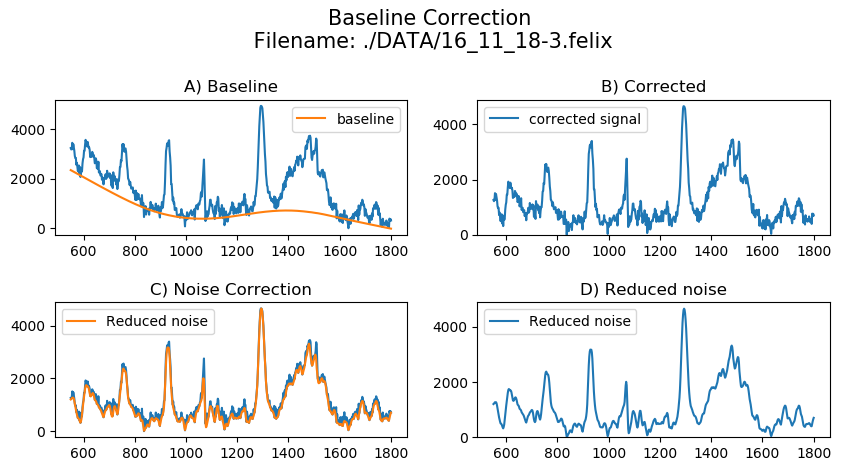

In [45]:
y_corrected, baseline = rp.baseline(x, y1,bir,"als",lam = v['lamb'], p = v['p_value'], niter = v['iterations'])

plt.figure()
plt.subplots_adjust(top=0.8, wspace = 0.2, hspace = 0.5)
plt.suptitle("Baseline Correction\n Filename: %s"%filename, fontsize = v['mainfont'])

plt.subplot(221)
plt.plot(x, y1)
plt.plot(x,baseline,label="baseline")
plt.title("A) Baseline", fontsize = v['subfont'])
plt.legend()

plt.subplot(222)
y_corrected = y_corrected-y_corrected.min()
plt.plot(x,y_corrected,label="corrected signal")
plt.title("B) Corrected", fontsize = v['subfont'])
plt.ylim(ymin=0)
plt.legend()

plt.subplot(223)
y_temp, y_smooth = rp.baseline(x, y_corrected,bir,"als",lam = v['smooth'])
plt.plot(x,y_corrected)
plt.plot(x, y_smooth, label = 'Reduced noise')
plt.title("C) Noise Correction", fontsize = v['subfont'])
plt.legend()

plt.subplot(224)
plt.plot(x, y_smooth, label = 'Reduced noise')
plt.title("D) Reduced noise", fontsize = v['subfont'])
plt.ylim(ymin=0)
plt.legend()

plt.show()
plt.close()

#Reshaping all the vaiables
x = x.reshape(shape,)
y1 = y1.reshape(shape,)
baseline = baseline.reshape(shape,)
y_corrected = y_corrected.reshape(shape,)
y_smooth = y_smooth.reshape(shape,)

# Power Calibration

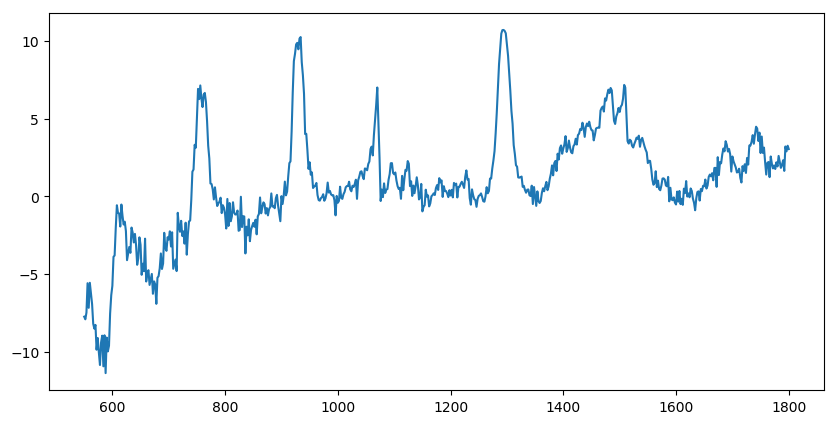

In [60]:
powerfile = './DATA/16_11_18-3.pow'
shots = 16.0

power = np.genfromtxt(powerfile)
power_wn, power_mj = power[:,0], power[:,1]

f = interpolate(power_wn, power_mj, kind = 'linear', fill_value = 'extrapolate')

power_extrapolated = f(x)*shots

y_norm = (y_corrected-baseline)/power_extrapolated
plt.plot(x, y_norm)

In [7]:
help(rp.baseline)

Help on function baseline in module rampy.baseline:

baseline(x_input, y_input, bir, method, **kwargs)
    Allows subtracting a baseline under a x y spectrum.
    
    Parameters
    ----------
    x_input : ndarray
        x values.
    y_input : ndarray
        y values.
    bir : ndarray
        Contain the regions of interest, organised per line. 
        For instance, roi = np.array([[100., 200.],[500.,600.]]) will 
        define roi between 100 and 200 as well as between 500 and 600.
        Note: This is NOT used by the "als" and "arPLS" algorithms, but still is a requirement when calling the function.
        bir and method probably will become args in a futur iteration of rampy to solve this.
    methods : str
        "poly": polynomial fitting, with splinesmooth the degree of the polynomial.
        "unispline": spline with the UnivariateSpline function of Scipy, splinesmooth is 
                     the spline smoothing factor (assume equal weight in the present case);
    